In [1]:
!pip install -r requirements.txt

Processing c:\b\abs_9ex6mi6b56\croot\aiofiles_1683773603390\work (from -r requirements.txt (line 1))

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\b\\abs_9ex6mi6b56\\croot\\aiofiles_1683773603390\\work'



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.cluster import KMeans
import seaborn as sns
#make imports

import warnings
warnings.filterwarnings("ignore")
#desactive warnings


defaultDf = pd.read_csv('./order-data-set.csv') #read csv file
defaultDf.info() #print schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                116581 non-null  object 
 1   id_costumer          116578 non-null  object 
 2   id_unique_costumer   116578 non-null  object 
 3   item_id              116578 non-null  float64
 4   cep_costumer         116578 non-null  float64
 5   city_costumer        116578 non-null  object 
 6   state_costumer       116578 non-null  object 
 7   id_order             116578 non-null  object 
 8   status_order         116578 non-null  object 
 9   order_time           116578 non-null  object 
 10  order_approved       116564 non-null  object 
 11  order_deliveryman    115365 non-null  object 
 12  order_delivered      114063 non-null  object 
 13  estimated_date       116578 non-null  object 
 14  id_seller            116578 non-null  object 
 15  price            

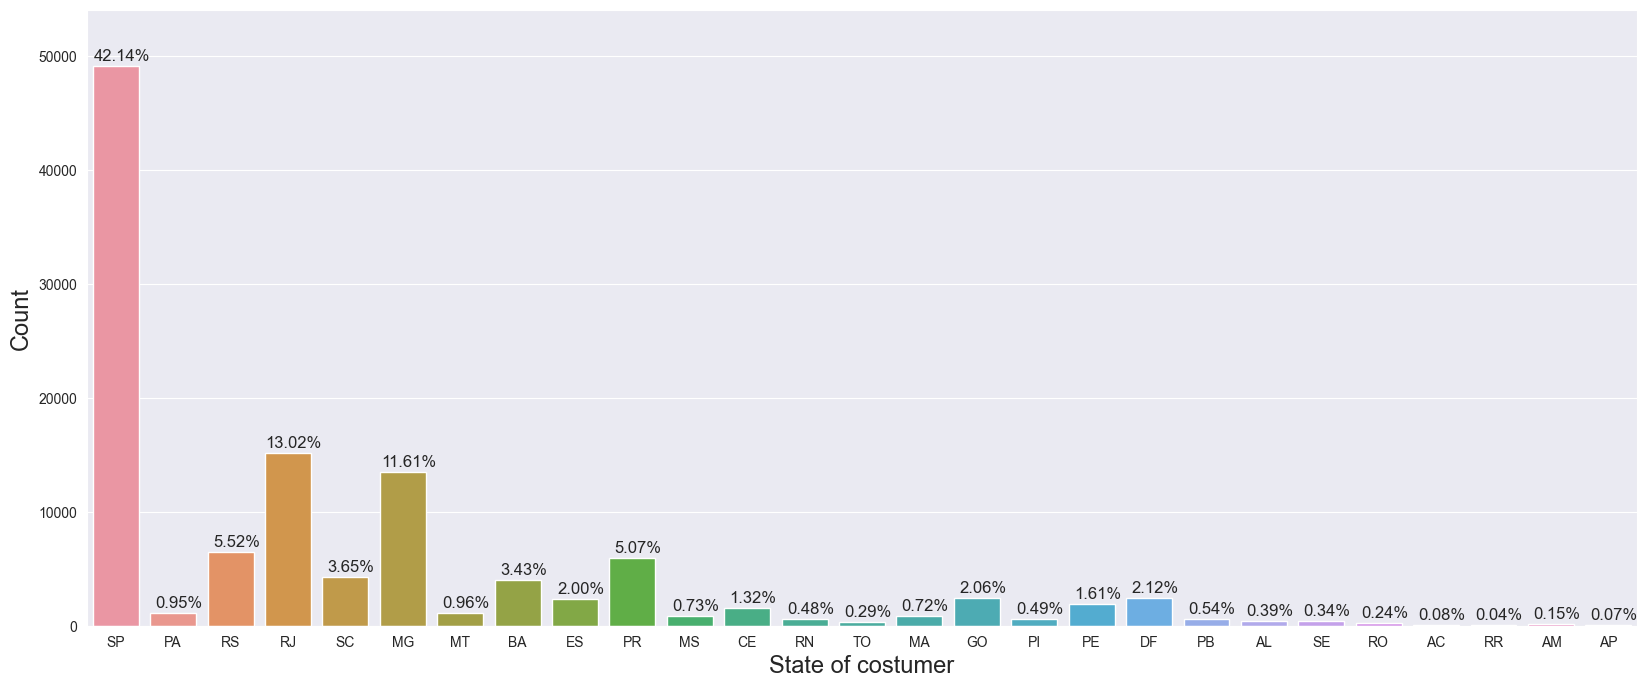

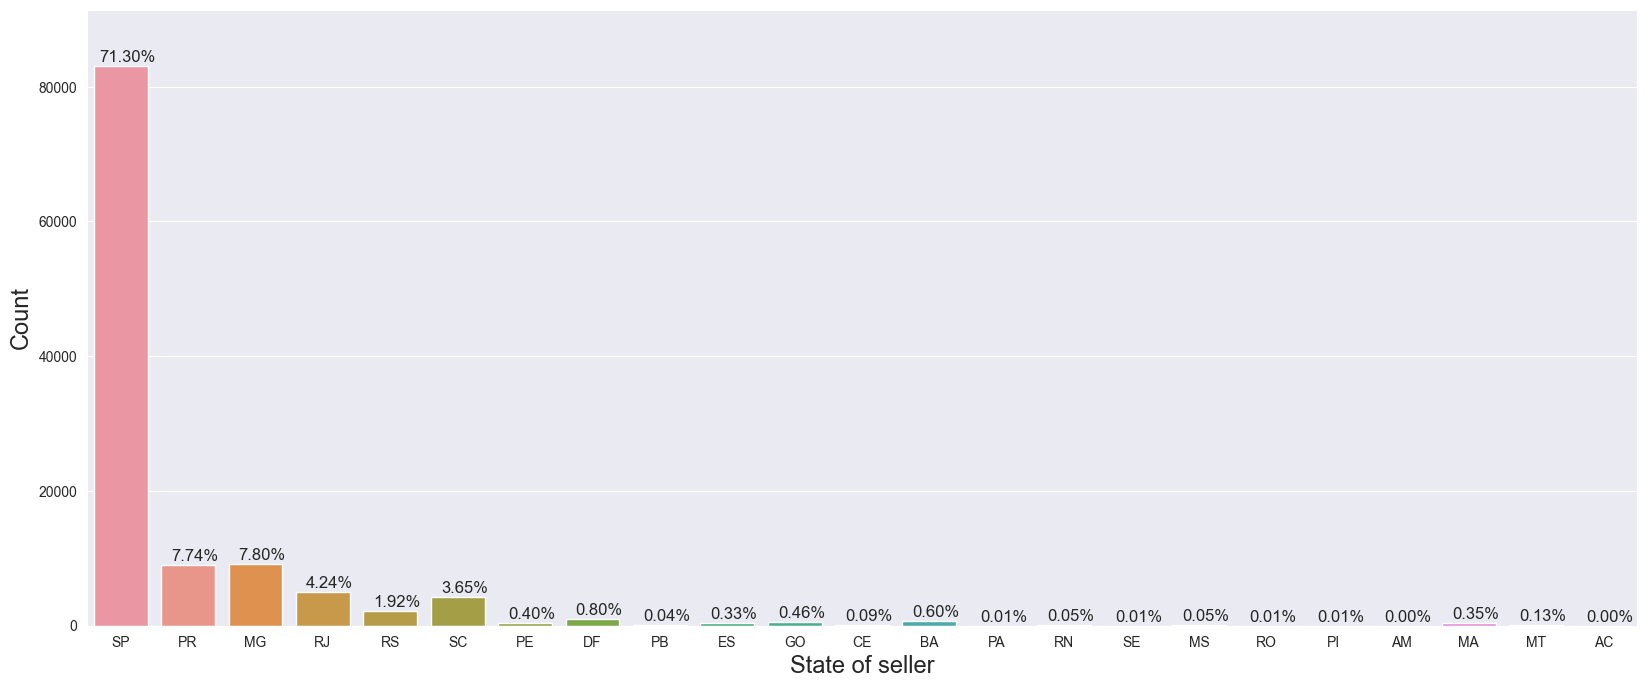

In [3]:
#studying some features in dataset

def plotPerc(dataframeColumn:str,data:DataFrame,xLabel:str):

    plt.figure(figsize=(20,8))

    g = sns.countplot(x=dataframeColumn,data=data,orient='h')
    g.set_ylabel("Count",fontsize=17)
    g.set_xlabel(xLabel,fontsize=17)

    sizes = []

    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x() + p.get_width()/1.6,
               height + 200,
               '{:1.2f}%'.format(height/116581*100),
               ha='center',
               va='bottom',
               fontsize=12,
               )
    g.set_ylim(0,max(sizes)*1.1)

plotPerc('state_costumer',defaultDf,"State of costumer") #counting purchases by each state
plotPerc('state_seller',defaultDf,"State of seller") #counting seller by each state

In [4]:
#calculating the recency of orders based on the date of the last order placed

dfTreated = defaultDf[['id_unique_costumer','id_costumer','order_time','item_id','price']]
dfOrder = dfTreated.groupby('id_unique_costumer').order_time.max().reset_index()
dfOrder.columns = ['id_unique_costumer','max_date_order']
dfOrder['max_date_order'] = pd.to_datetime(dfOrder['max_date_order'])
dfOrder['recency'] = (dfOrder['max_date_order'].max() - dfOrder['max_date_order']).dt.days #decrements each row of the max_order_date column in the dforder dataframe by the last purchase made with information in the dataset

dfOrderCostumer = pd.merge(dfTreated,dfOrder[['id_unique_costumer','recency']],on='id_unique_costumer')

#dfOrderCostumer.head() #print 5 first lines of dfOrderCostumer

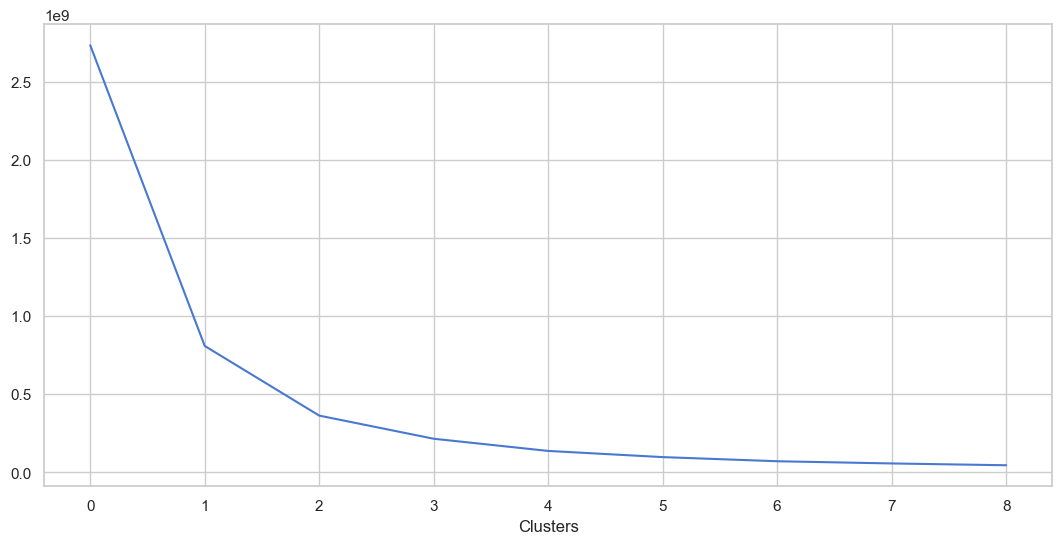

In [9]:
# defining the best number of clusters using the elbow method and the point-line distance function

def calculateWcss(data) -> list:
    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X=data)
        data["clusters"] = kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

def distancePointLine(wcss:list) -> int:
    import math
    x1, y1 = 2,wcss[0]
    x2,y2 = 20,wcss[len(wcss)-1]

    distance = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        distance.append(numerator/denominator)
    return distance.index(max(distance)) + 2

def plotFigure(quadraticSum:list,figsize:tuple[int]):
    plt.figure(figsize=figsize)
    plt.plot(quadraticSum)
    plt.xlabel("Clusters")
    plt.show()

dfRecencyModel = dfOrderCostumer[['recency']]
quadraticSum = calculateWcss(dfRecencyModel)
nmrCluster = distancePointLine(quadraticSum)
plotFigure(quadraticSum,(13,6))
#print(nmrCluster) #4

In [12]:
def orderCluster(clusterName:str,target_name:str,dataframe:DataFrame,dfAppend,ascending:bool) ->DataFrame:
    kmeans = KMeans(n_clusters=nmrCluster)

    dfUse = dfAppend
    dfUse[clusterName] = kmeans.fit_predict(dataframe)

    groupbyCluster = dfUse.groupby(clusterName)[target_name].mean().reset_index()
    groupbyCluster = groupbyCluster.sort_values(by=target_name,ascending=ascending).reset_index(drop=True)
    groupbyCluster['index'] = groupbyCluster.index
    groupbyCluster.drop(columns=[target_name],inplace=True)
    dfUsageMerged = pd.merge(dfUse,groupbyCluster, on=clusterName)
    dfUsageMerged.drop(columns=[clusterName],inplace=True)
    dfUsageMerged.rename(columns={"index":clusterName},inplace=True)
    return dfUsageMerged

dfRecency = orderCluster("recency_cluster","recency",dfRecencyModel,dfOrderCostumer,False)

dfFrequency = defaultDf.groupby("id_unique_costumer")['order_approved'].count().reset_index()
dfMain = pd.merge(dfRecency,dfFrequency,on='id_unique_costumer')
dfFrequencyModel = dfMain[['order_approved']]
dfMain = orderCluster('frequency_cluster','order_approved',dfFrequencyModel,dfMain,True)

dfRevenue = defaultDf.groupby('id_unique_costumer')['payment_value'].sum().reset_index()
dfRevenue.rename(columns={'payment_value':'agg_value'},inplace=True)
dfMain = pd.merge(dfMain,dfRevenue,on='id_unique_costumer')
dfRevenueModel = dfMain[['agg_value']]
dfMain = orderCluster('revenue_cluster','agg_value',dfRevenueModel,dfMain,True)

finalDataframe = dfMain[['id_unique_costumer','recency','recency_cluster','order_approved','frequency_cluster','agg_value','revenue_cluster']]
finalDataframe['pontuation'] = finalDataframe['recency_cluster'] + finalDataframe['frequency_cluster'] + finalDataframe['revenue_cluster']
finalDataframe['segmentation'] = 'Inactive'
finalDataframe.loc[finalDataframe['pontuation']>1,'segmentation'] = 'Business'
finalDataframe.loc[finalDataframe['pontuation']>3,'segmentation'] = 'Master'
finalDataframe.loc[finalDataframe['pontuation']>5,'segmentation'] = 'Premium'

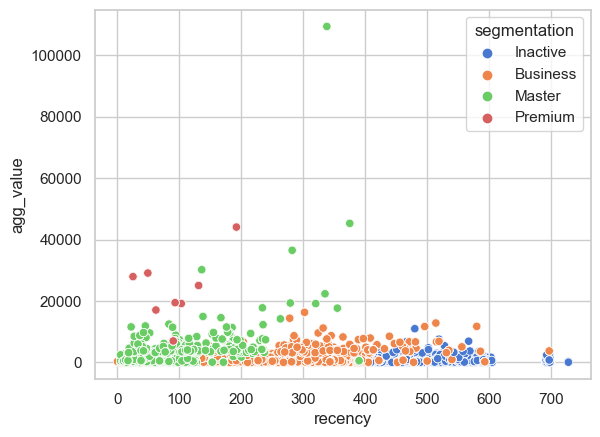

In [15]:
def plot_segment(x,y,data):
    sns.set(palette='muted',color_codes=True,style='whitegrid')
    #fig, axs = plt.subplots(1, 1, figsize=(7, 5))
    sns.scatterplot(x=x,y=y,hue='segmentation',data=data,sizes=(50,150),size_order=['Premium','Master','Business','Inativo'])
    plt.show()

plot_segment('recency','order_approved',finalDataframe)
plot_segment('order_approved','agg_value',finalDataframe)
plot_segment('recency','agg_value',finalDataframe)
plot_segment('agg_value','recency',finalDataframe)